In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import yaml

import graphframes as gf
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Column

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

plt.style.use("seaborn-white")
conf_dict = yaml.safe_load(Path("config/conf.yaml").read_text())

checkpoint_dir = str(Path("spark-checkpoints").absolute())
graphframes_jar_path = str(
    Path(
        ".venv/lib/python3.9/site-packages/pyspark/jars/graphframes-0.8.2-spark3.1-s_2.12.jar"
    ).absolute()
)

spark_conf = (
    SparkConf()
    .set("spark.jars", graphframes_jar_path)
    .set("spark.sql.sources.partitionOverwriteMode", "dynamic")
)

sc = SparkContext(conf=spark_conf).getOrCreate()
sc.setCheckpointDir(checkpoint_dir)
sc.setLogLevel("ERROR")

spark = SparkSession.builder.config("spark.driver.memory", "8g").getOrCreate()

22/07/16 18:01:42 WARN Utils: Your hostname, domvwt-XPS-13-9305 resolves to a loopback address: 127.0.1.1; using 192.168.0.24 instead (on interface wlp164s0)
22/07/16 18:01:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/07/16 18:01:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
companies_nodes_df = spark.read.parquet(conf_dict["companies_nodes"])
persons_nodes_df = spark.read.parquet(conf_dict["persons_nodes"])
edges_df = spark.read.parquet(conf_dict["edges"])

In [3]:
print(f"Companies count: {companies_nodes_df.count():,}")
print(f"Persons count: {persons_nodes_df.count():,}")
print(f"Edge count: {edges_df.count():,}")

Companies count: 96,547
Persons count: 36,757
Edge count: 135,132


In [4]:
select_cols = ["id", "component", "isCompany"]
all_nodes = companies_nodes_df.select(select_cols).union(persons_nodes_df.select(select_cols))

In [5]:
all_nodes

DataFrame[id: string, component: bigint, isCompany: boolean]

In [19]:
component_summary = (
    all_nodes.groupBy("component", "isCompany")
    .count()
    .groupBy("component")
    .pivot("isCompany", ["true", "false"])
    .agg(F.sum("count"))
    .withColumnRenamed("true", "company_count")
    .withColumnRenamed("false", "person_count")
    .withColumn("person_proportion", F.col("person_count") / F.col("company_count"))
    .fillna(0)
    .orderBy("person_proportion", ascending=False)
)
component_summary.show()

+------------+-------------+------------+------------------+
|   component|company_count|person_count| person_proportion|
+------------+-------------+------------+------------------+
|       32537|            1|          15|              15.0|
|257698064439|            1|          12|              12.0|
|206158475927|            1|          11|              11.0|
|  8589940483|            1|          11|              11.0|
|120259129243|            1|          10|              10.0|
|111669155269|            1|           9|               9.0|
| 68719542280|            1|           9|               9.0|
| 60129548063|            2|          16|               8.0|
|       18815|            2|          10|               5.0|
| 17179914106|            2|          10|               5.0|
| 42949726713|            2|          10|               5.0|
|171798701224|            2|          10|               5.0|
|420906812779|            2|           8|               4.0|
|317827622330|          

In [31]:
component_summary.orderBy("person_proportion").show()

+------------+-------------+------------+-----------------+
|   component|company_count|person_count|person_proportion|
+------------+-------------+------------+-----------------+
|206158442098|           10|           1|              0.1|
|188978592395|           10|           1|              0.1|
| 17179931635|           10|           1|              0.1|
| 85899368939|           10|           1|              0.1|
|171798753466|           10|           1|              0.1|
|128849022235|           10|           1|              0.1|
|352187373820|           10|           1|              0.1|
|171798707458|           20|           2|              0.1|
| 42949673419|           10|           1|              0.1|
| 42949733341|           10|           1|              0.1|
| 77309455172|           10|           1|              0.1|
|146028902698|           10|           1|              0.1|
| 68719480689|           10|           1|              0.1|
|  8589967999|           10|           1

In [25]:
components_summary_pd = component_summary.toPandas()

<AxesSubplot:ylabel='Frequency'>

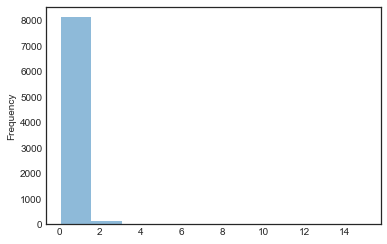

In [47]:
components_summary_pd.query("person_proportion > 0.1 & person_proportion < 1")["person_proportion"].plot.hist(bins=10, alpha=0.5)

In [33]:
components_summary_pd

,component,company_count,person_count,person_proportion
0,32537,1,15,15.0
1,257698064439,1,12,12.0
2,8589940483,1,11,11.0
3,206158475927,1,11,11.0
4,120259129243,1,10,10.0
...,...,...,...,...
8581,8589971231,10,1,0.1
8582,335007476673,10,1,0.1
8583,25769837299,10,1,0.1
8584,103079221259,10,1,0.1


<AxesSubplot:ylabel='Frequency'>

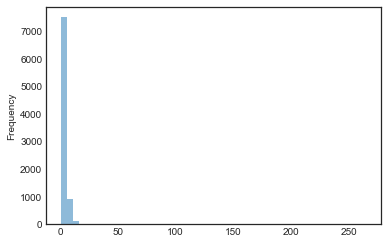

In [34]:
components_summary_pd["person_count"].plot.hist(bins=50, alpha=0.5)

In [35]:
components_summary_pd.query("person_count > 0").tail()

,component,company_count,person_count,person_proportion
8581,8589971231,10,1,0.1
8582,335007476673,10,1,0.1
8583,25769837299,10,1,0.1
8584,103079221259,10,1,0.1
8585,60129594486,10,1,0.1


In [36]:
companies_nodes_df.filter(F.col("component") == "8589942400").toPandas()

,id,isCompany,component,name,foundingDate,dissolutionDate,countryCode,companiesHouseID,openCorporatesID,openOwnershipRegisterID,CompanyCategory,CompanyStatus,Accounts_AccountCategory,SICCode_SicText_1


In [37]:
persons_nodes_df.filter(F.col("component") == "8589942400").toPandas()


,id,isCompany,component,birthDate,name,nationality


In [38]:
companies_nodes_df.filter(F.col("component").isNull()).toPandas()

,id,isCompany,component,name,foundingDate,dissolutionDate,countryCode,companiesHouseID,openCorporatesID,openOwnershipRegisterID,CompanyCategory,CompanyStatus,Accounts_AccountCategory,SICCode_SicText_1


In [39]:
companies_nodes_df.columns

['id',
 'isCompany',
 'component',
 'name',
 'foundingDate',
 'dissolutionDate',
 'countryCode',
 'companiesHouseID',
 'openCorporatesID',
 'openOwnershipRegisterID',
 'CompanyCategory',
 'CompanyStatus',
 'Accounts_AccountCategory',
 'SICCode_SicText_1']

In [40]:
companies_nodes_df.filter(F.col("name").isNull()).toPandas()

,id,isCompany,component,name,foundingDate,dissolutionDate,countryCode,companiesHouseID,openCorporatesID,openOwnershipRegisterID,CompanyCategory,CompanyStatus,Accounts_AccountCategory,SICCode_SicText_1
0,13263911563944180045,True,94489297890,None,None,None,GB,13536622,None,http://register.openownership.org/entities/610...,Private Limited Company,Active,NO ACCOUNTS FILED,68100 - Buying and selling of own real estate
1,15032184123090580598,True,77309455143,None,None,None,GB,13520961,None,http://register.openownership.org/entities/60f...,Private Limited Company,Active,NO ACCOUNTS FILED,43290 - Other construction installation
2,1594164572366880885,True,77309438912,None,None,None,GB,13532207,None,http://register.openownership.org/entities/610...,Private Limited Company,Active,NO ACCOUNTS FILED,99999 - Dormant Company
3,3684534180296136072,True,23065,None,None,None,GB,13547263,None,http://register.openownership.org/entities/610...,Private Limited Company,Active,NO ACCOUNTS FILED,98000 - Residents property management
4,17932208400311361226,True,25769805039,None,None,None,GB,13539518,None,http://register.openownership.org/entities/610...,Private Limited Company,Active,NO ACCOUNTS FILED,64921 - Credit granting by non-deposit taking ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,17647701017630119736,True,30603,None,None,None,GB,13514449,None,http://register.openownership.org/entities/60f...,Private Limited Company,Active,NO ACCOUNTS FILED,10890 - Manufacture of other food products n.e.c.
457,10168366228266865725,True,17179912213,None,None,None,GB,13547533,None,http://register.openownership.org/entities/610...,Private Limited Company,Active,NO ACCOUNTS FILED,68209 - Other letting and operating of own or ...
458,13066924491009725446,True,49399,None,None,None,GB,13514842,None,http://register.openownership.org/entities/60f...,Private Limited Company,Active,NO ACCOUNTS FILED,72110 - Research and experimental development ...
459,2450302090764688576,True,25769823588,None,None,None,GB,13534602,None,http://register.openownership.org/entities/610...,Private Limited Company,Active,NO ACCOUNTS FILED,99999 - Dormant Company
